<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import uuid
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:


def detect_duplicates(folder):
    
    seen = {}
    duplicates = {}
    for cls in os.listdir(folder):
        class_path = os.path.join(folder, cls)
        if not os.path.isdir(class_path):
            continue
        duplicates[cls] = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_hash = hash(img.tobytes())
                if img_hash in seen:
                    duplicates[cls].append(img_path)
                else:
                    seen[img_hash] = img_path
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return duplicates

def augment_image(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def augment_duplicates(folder, duplicates_per_class, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cls, duplicate_files in duplicates_per_class.items():
        class_output_path = os.path.join(output_folder, cls)
        os.makedirs(class_output_path, exist_ok=True)
        for filepath in duplicate_files:
            try:
                with Image.open(filepath) as img:
                    augmented_img = augment_image(img)
                    new_filename = f"{os.path.splitext(os.path.basename(filepath))[0]}_{uuid.uuid4().hex[:6]}.png"
                    new_filepath = os.path.join(class_output_path, new_filename)
                    augmented_img.save(new_filepath)
            except Exception as e:
                print(f"Error augmenting {filepath}: {e}")

In [ ]:

# Paths
dataset_path = "D:/Datasets_Retina"
final_dataset_path = "D:/Datasets_Final"
model_save_path = "D:/saved_model_fundus.h5"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
K_FOLDS = 3  

# Function for Image Preprocessing
def preprocess_image(img_path):
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        img = img.resize(IMG_SIZE)  # Resize to target size
        img = np.array(img) / 255.0  
        return img
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None


In [ ]:

# Load Data
all_images = []
all_labels = []

for cls in os.listdir(os.path.join(final_dataset_path, "train")):
    class_path = os.path.join(final_dataset_path, "train", cls)
    label = 1 if cls == "Fundus" else 0  # Binary classification
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            all_images.append(img_path)
            all_labels.append(label)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\nTraining Fold {fold + 1}/{K_FOLDS}...\n")

    train_images, val_images = all_images[train_idx], all_images[val_idx]
    train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]

    train_df = pd.DataFrame({"filename": train_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in train_labels]})
    val_df = pd.DataFrame({"filename": val_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in val_labels]})


    # Data Augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.3,
        shear_range=0.2,
        brightness_range=[0.7, 1.3]
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col="filename", y_col="class",
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="binary", shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col="filename", y_col="class",
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="binary", shuffle=False
    )

    # Optimized CNN Model
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks for Early Stopping and Best Model Saving
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Train Model
    model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping, checkpoint])

    # Evaluate Model
    val_loss, val_accuracy = model.evaluate(val_generator)
    fold_accuracies.append(val_accuracy * 100)
    print(f"Fold {fold+1} Validation Accuracy: {val_accuracy * 100:.2f}%")

# Compute Final Cross-Validation Accuracy
final_accuracy = np.mean(fold_accuracies)
print(f"\nFinal Cross-Validated Accuracy: {final_accuracy:.2f}%")
best_model = tf.keras.models.load_model(model_save_path)

# Test Data Evaluation
test_generator = val_datagen.flow_from_directory(
    os.path.join(final_dataset_path, "test"),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=False
)

y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Fundus", "Fundus"]))

best_model.save(model_save_path)
print(f"\nModel saved at: {model_save_path}")



Training Fold 1/3...

Found 3481 validated image filenames belonging to 2 classes.
Found 1741 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9208 - loss: 3.0141

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9211 - loss: 3.0100 - val_accuracy: 0.5445 - val_loss: 50.2085
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.9532 - loss: 2.2498 - val_accuracy: 0.5445 - val_loss: 44.5896
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9686 - loss: 1.9827

109/109 ━━━━━━━━━━━━━━━━━━━━ 420s 4s/step - accuracy: 0.9686 - loss: 1.9817 - val_accuracy: 0.5589 - val_loss: 23.8171
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9703 - loss: 1.8500

109/109 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9703 - loss: 1.8491 - val_accuracy: 0.6479 - val_loss: 22.9004
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9642 - loss: 1.8123

109/109 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9643 - loss: 1.8109 - val_accuracy: 0.8909 - val_loss: 4.0235
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9808 - loss: 1.4421

109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9808 - loss: 1.4418 - val_accuracy: 0.9150 - val_loss: 5.2394
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9825 - loss: 1.3709

109/109 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step - accuracy: 0.9825 - loss: 1.3706 - val_accuracy: 0.9696 - val_loss: 2.0538
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.9806 - loss: 1.2586 - val_accuracy: 0.9563 - val_loss: 2.3374
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9757 - loss: 1.1993

109/109 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9757 - loss: 1.1996 - val_accuracy: 0.9793 - val_loss: 1.6569
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - accuracy: 0.9787 - loss: 1.1861 - val_accuracy: 0.9742 - val_loss: 1.6485
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.9787 - loss: 1.1588 - val_accuracy: 0.9736 - val_loss: 1.4696
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.9858 - loss: 1.0853 - val_accuracy: 0.9638 - val_loss: 1.5836
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9782 - loss: 1.0154 - val_accuracy: 0.9742 - val_loss: 1.4151
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.9807 - loss: 0.9992 - val_accuracy: 0.9500 - val_loss: 2.0057
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9816 - loss: 0.9783

109/109 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.9816 - loss: 0.9781 - val_accuracy: 0.9805 - val_loss: 1.2149
Epoch 16/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9833 - loss: 0.8815 - val_accuracy: 0.9765 - val_loss: 1.2491
Epoch 17/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9790 - loss: 0.8762 - val_accuracy: 0.9799 - val_loss: 1.0367
Epoch 18/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9803 - loss: 0.8632 - val_accuracy: 0.9615 - val_loss: 1.3185
Epoch 19/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.9792 - loss: 0.8680 - val_accuracy: 0.6623 - val_loss: 4.4782
Epoch 20/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9675 - loss: 1.2353

109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9675 - loss: 1.2358 - val_accuracy: 0.9851 - val_loss: 1.6433
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9924 - loss: 0.8970
Fold 1 Validation Accuracy: 97.99%

Training Fold 2/3...

Found 3481 validated image filenames belonging to 2 classes.
Found 1741 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9245 - loss: 3.0907

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9247 - loss: 3.0863 - val_accuracy: 0.5439 - val_loss: 31.0364
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 814s 7s/step - accuracy: 0.9682 - loss: 1.8253 - val_accuracy: 0.5439 - val_loss: 39.0930
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9747 - loss: 1.6873

109/109 ━━━━━━━━━━━━━━━━━━━━ 788s 7s/step - accuracy: 0.9746 - loss: 1.6879 - val_accuracy: 0.5485 - val_loss: 37.0861
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9708 - loss: 1.7950

109/109 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - accuracy: 0.9708 - loss: 1.7948 - val_accuracy: 0.6904 - val_loss: 14.7714
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9766 - loss: 1.7369

109/109 ━━━━━━━━━━━━━━━━━━━━ 781s 7s/step - accuracy: 0.9766 - loss: 1.7362 - val_accuracy: 0.8334 - val_loss: 10.6510
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9738 - loss: 1.7707

109/109 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.9738 - loss: 1.7699 - val_accuracy: 0.9495 - val_loss: 2.9009
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.9749 - loss: 1.5567 - val_accuracy: 0.9282 - val_loss: 4.4378
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 418s 4s/step - accuracy: 0.9841 - loss: 1.3457 - val_accuracy: 0.9385 - val_loss: 3.4215
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9815 - loss: 1.3839

109/109 ━━━━━━━━━━━━━━━━━━━━ 418s 4s/step - accuracy: 0.9814 - loss: 1.3837 - val_accuracy: 0.9540 - val_loss: 2.4120
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9864 - loss: 1.2951

109/109 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.9864 - loss: 1.2947 - val_accuracy: 0.9604 - val_loss: 1.7103
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 537s 5s/step - accuracy: 0.9875 - loss: 1.1492 - val_accuracy: 0.9558 - val_loss: 2.0964
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9873 - loss: 1.0774

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9873 - loss: 1.0774 - val_accuracy: 0.9678 - val_loss: 1.5329
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9856 - loss: 1.0321 - val_accuracy: 0.9540 - val_loss: 1.7486
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.9879 - loss: 0.9643 - val_accuracy: 0.9495 - val_loss: 1.7137
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9848 - loss: 0.9308 - val_accuracy: 0.9489 - val_loss: 1.8907
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9889 - loss: 1.1853
Fold 2 Validation Accuracy: 96.78%

Training Fold 3/3...

Found 3482 validated image filenames belonging to 2 classes.
Found 1740 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9106 - loss: 3.9483

109/109 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.9109 - loss: 3.9430 - val_accuracy: 0.5443 - val_loss: 27.6377
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9671 - loss: 1.7858 - val_accuracy: 0.5443 - val_loss: 30.9467
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9759 - loss: 1.5642

109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9758 - loss: 1.5647 - val_accuracy: 0.5741 - val_loss: 15.3393
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9672 - loss: 1.5496

109/109 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9673 - loss: 1.5489 - val_accuracy: 0.7586 - val_loss: 8.7484
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9777 - loss: 1.3549

109/109 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.9777 - loss: 1.3552 - val_accuracy: 0.9006 - val_loss: 4.2775
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9805 - loss: 1.2472

109/109 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9805 - loss: 1.2473 - val_accuracy: 0.9247 - val_loss: 4.1805
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9773 - loss: 1.1780

109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9773 - loss: 1.1778 - val_accuracy: 0.9391 - val_loss: 3.3243
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9844 - loss: 1.1052

109/109 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9844 - loss: 1.1051 - val_accuracy: 0.9477 - val_loss: 2.9299
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9840 - loss: 1.0469

109/109 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9840 - loss: 1.0468 - val_accuracy: 0.9546 - val_loss: 2.5376
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 420s 4s/step - accuracy: 0.9754 - loss: 1.1059 - val_accuracy: 0.9471 - val_loss: 2.7728
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.9682 - loss: 1.1749 - val_accuracy: 0.9224 - val_loss: 3.4382
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.9816 - loss: 1.0418 - val_accuracy: 0.9466 - val_loss: 2.3700
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9759 - loss: 1.0981

109/109 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9758 - loss: 1.0984 - val_accuracy: 0.9718 - val_loss: 1.5386
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9831 - loss: 1.0326 - val_accuracy: 0.9655 - val_loss: 1.9559
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.9813 - loss: 0.9357 - val_accuracy: 0.9592 - val_loss: 2.2907
Epoch 16/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9828 - loss: 0.8894 - val_accuracy: 0.9511 - val_loss: 2.6182
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9882 - loss: 1.2027
Fold 3 Validation Accuracy: 97.18%

Final Cross-Validated Accuracy: 97.32%


Found 748 images belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step



Final Classification Report:
              precision    recall  f1-score   support

  Non-Fundus       0.97      1.00      0.98       407
      Fundus       1.00      0.96      0.98       341

    accuracy                           0.98       748
   macro avg       0.98      0.98      0.98       748
weighted avg       0.98      0.98      0.98       748


Model saved at: D:/saved_model_fundus.h5


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("D:/saved_model_fundus.h5")
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9911 - loss: 1.0744
Test Accuracy: 98.13%
Test Loss: 1.2224


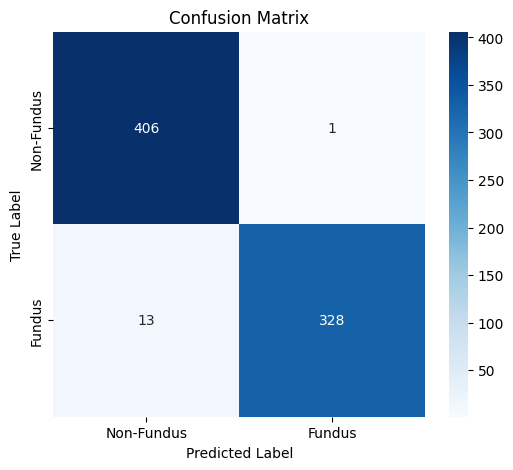

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fundus", "Fundus"], yticklabels=["Non-Fundus", "Fundus"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = "D:/saved_model_fundus.h5"

start_time = time.time()
model = load_model(model_path)
end_time = time.time()

print(f"Model loaded in {end_time - start_time:.2f} seconds")


Model loaded in 0.87 seconds


In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model_path = "D:/saved_model_fundus.h5"
model = tf.keras.models.load_model(model_path)



In [ ]:
img_path = r"D:\Datasets_Final\test\Fundus\N3.jpg"
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  

prediction = model.predict(img_array)

# Check output
print("Prediction:", prediction)

# Interpret the prediction based on your labeling (e.g., 0 = fundus, 1 = non-fundus)
if prediction[0] > 0.5:
    print("Model predicts: Non-Fundus")
else:
    print("Model predicts: Fundus")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: [[1.233044e-19]]
Model predicts: Fundus


In [ ]:
test_image_path = "C:\\Users\\User\\Downloads\\download.jpeg"
input_image = preprocess_single_image(test_image_path)
prediction = model.predict(input_image)

# Interpret Prediction
class_labels = ["Non-Fundus", "Fundus"]
predicted_class = class_labels[int(prediction[0] > 0.5)]
print(f"Predicted Class: {predicted_class} (Confidence: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Class: Non-Fundus (Confidence: 0.0000)


C:\Users\User\AppData\Local\Temp\ipykernel_19436\4066659428.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]



Training Fold 1/3...


Training Labels Preview:
                                          filename   class
0  D:/Datasets_Final\train\Fundus\0024cdab0c1e.png  Fundus
1  D:/Datasets_Final\train\Fundus\0097f532ac9f.png  Fundus
2  D:/Datasets_Final\train\Fundus\00a8624548a9.png  Fundus
3  D:/Datasets_Final\train\Fundus\00b74780d31d.png  Fundus
4  D:/Datasets_Final\train\Fundus\00f6c1be5a33.png  Fundus

Validation Labels Preview:
                                          filename   class
0  D:/Datasets_Final\train\Fundus\000c1434d8d7.png  Fundus
1  D:/Datasets_Final\train\Fundus\00cc2b75cddd.png  Fundus
2  D:/Datasets_Final\train\Fundus\0124dffecf29.png  Fundus
3  D:/Datasets_Final\train\Fundus\01b3aed3ed4c.png  Fundus
4  D:/Datasets_Final\train\Fundus\01c7808d901d.png  Fundus
Found 3481 validated image filenames belonging to 2 classes.
Found 1741 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8485 - loss: 0.5027

109/109 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.8492 - loss: 0.5014 - val_accuracy: 0.9742 - val_loss: 0.2387
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9699 - loss: 0.2232 - val_accuracy: 0.9449 - val_loss: 0.2368
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9837 - loss: 0.1733 - val_accuracy: 0.9661 - val_loss: 0.1784
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9827 - loss: 0.1520 - val_accuracy: 0.9696 - val_loss: 0.1676
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9829 - loss: 0.1353 - val_accuracy: 0.9736 - val_loss: 0.1465
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9901 - loss: 0.1189

109/109 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.9901 - loss: 0.1189 - val_accuracy: 0.9776 - val_loss: 0.1367
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9865 - loss: 0.1118

109/109 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9865 - loss: 0.1118 - val_accuracy: 0.9845 - val_loss: 0.1132
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9941 - loss: 0.1019 - val_accuracy: 0.9667 - val_loss: 0.1511
Epoch 9/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9892 - loss: 0.0989 - val_accuracy: 0.9759 - val_loss: 0.1193
Epoch 10/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9912 - loss: 0.0870 - val_accuracy: 0.9765 - val_loss: 0.1218
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9943 - loss: 0.0900
Fold 1 Validation Accuracy: 98.45%

Training Fold 2/3...


Training Labels Preview:
                                          filename   class
0  D:/Datasets_Final\train\Fundus\000c1434d8d7.png  Fundus
1  D:/Datasets_Final\train\Fundus\0024cdab0c1e.png  Fundus
2  D:/Datasets_Final\train\Fundus\00cc2b75cddd.png  Fundus
3  D:/Datasets_Final\train\Fundus\0124dffecf29.png  Fundus
4  D:/Datasets_Final\train\Fundus\0125fbd2

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8326 - loss: 0.5422

109/109 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.8333 - loss: 0.5406 - val_accuracy: 0.8989 - val_loss: 0.3684
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9763 - loss: 0.2166

109/109 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9763 - loss: 0.2166 - val_accuracy: 0.9563 - val_loss: 0.2356
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9769 - loss: 0.1810

109/109 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.9769 - loss: 0.1810 - val_accuracy: 0.9575 - val_loss: 0.2166
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9780 - loss: 0.1642 - val_accuracy: 0.9495 - val_loss: 0.2389
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9855 - loss: 0.1332

109/109 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.9855 - loss: 0.1332 - val_accuracy: 0.9615 - val_loss: 0.1917
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9893 - loss: 0.1182

109/109 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9893 - loss: 0.1182 - val_accuracy: 0.9650 - val_loss: 0.1784
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9882 - loss: 0.1095 - val_accuracy: 0.9345 - val_loss: 0.2429
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9928 - loss: 0.0975 - val_accuracy: 0.9638 - val_loss: 0.1830
Epoch 9/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.9925 - loss: 0.0965 - val_accuracy: 0.9449 - val_loss: 0.2079
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9868 - loss: 0.1179
Fold 2 Validation Accuracy: 96.50%

Training Fold 3/3...


Training Labels Preview:
                                          filename   class
0  D:/Datasets_Final\train\Fundus\000c1434d8d7.png  Fundus
1  D:/Datasets_Final\train\Fundus\0097f532ac9f.png  Fundus
2  D:/Datasets_Final\train\Fundus\00a8624548a9.png  Fundus
3  D:/Datasets_Final\train\Fundus\00b74780d31d.png  Fundus
4  D:/Datasets_Final\train\Fundus\00cc2b75c

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.3726

109/109 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9130 - loss: 0.3717 - val_accuracy: 0.9707 - val_loss: 0.2101
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9761 - loss: 0.1801

109/109 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.9761 - loss: 0.1800 - val_accuracy: 0.9747 - val_loss: 0.1771
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9827 - loss: 0.1421

109/109 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.9827 - loss: 0.1420 - val_accuracy: 0.9770 - val_loss: 0.1588
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9904 - loss: 0.1103 - val_accuracy: 0.9747 - val_loss: 0.1560
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9892 - loss: 0.1079

109/109 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9892 - loss: 0.1078 - val_accuracy: 0.9799 - val_loss: 0.1340
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9896 - loss: 0.1037 - val_accuracy: 0.9753 - val_loss: 0.1433
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9946 - loss: 0.0819 - val_accuracy: 0.9799 - val_loss: 0.1237
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9945 - loss: 0.0754

109/109 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.9945 - loss: 0.0755 - val_accuracy: 0.9816 - val_loss: 0.1123
Epoch 9/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.9920 - loss: 0.0771 - val_accuracy: 0.9793 - val_loss: 0.1148
Epoch 10/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9940 - loss: 0.0678 - val_accuracy: 0.9787 - val_loss: 0.1235
Epoch 11/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9954 - loss: 0.0638 - val_accuracy: 0.9810 - val_loss: 0.1030
Epoch 12/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9956 - loss: 0.0616

109/109 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9956 - loss: 0.0617 - val_accuracy: 0.9862 - val_loss: 0.0854
Epoch 13/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9959 - loss: 0.0607 - val_accuracy: 0.9856 - val_loss: 0.0867
Epoch 14/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9926 - loss: 0.0650 - val_accuracy: 0.9810 - val_loss: 0.1089
Epoch 15/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9967 - loss: 0.0568 - val_accuracy: 0.9845 - val_loss: 0.0972
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9936 - loss: 0.0650
Fold 3 Validation Accuracy: 98.62%

Final Cross-Validated Accuracy: 97.86%


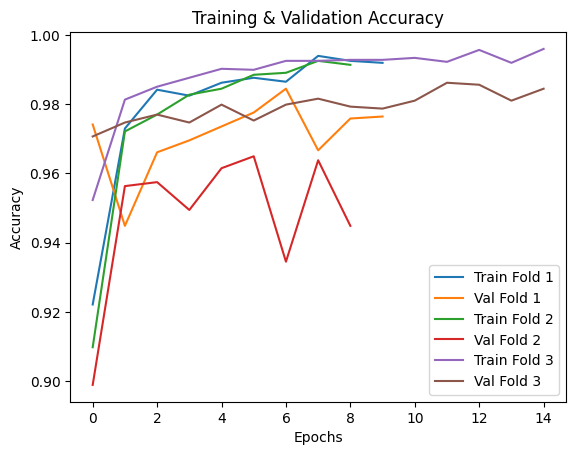

Found 748 images belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


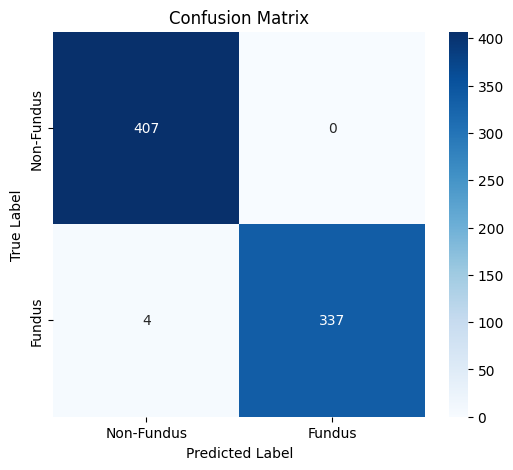


Final Classification Report:
              precision    recall  f1-score   support

  Non-Fundus       0.99      1.00      1.00       407
      Fundus       1.00      0.99      0.99       341

    accuracy                           0.99       748
   macro avg       1.00      0.99      0.99       748
weighted avg       0.99      0.99      0.99       748


Model saved at: D:/cnn_model_fundus.h5


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths
dataset_path = "D:/Datasets_Retina"
final_dataset_path = "D:/Datasets_Final"
model_save_path = "D:/saved_model_fundus.h5"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
K_FOLDS = 3  

# Function for Image Preprocessing
def preprocess_image(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(IMG_SIZE)
        img = np.array(img) / 255.0
        return img
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Load Data
all_images = []
all_labels = []

for cls in os.listdir(os.path.join(final_dataset_path, "train")):
    class_path = os.path.join(final_dataset_path, "train", cls)
    label = 1 if cls == "Fundus" else 0
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            all_images.append(img_path)
            all_labels.append(label)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_accuracies = []
history_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\nTraining Fold {fold + 1}/{K_FOLDS}...\n")

    train_images, val_images = all_images[train_idx], all_images[val_idx]
    train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]

    train_df = pd.DataFrame({"filename": train_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in train_labels]})
    val_df = pd.DataFrame({"filename": val_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in val_labels]})

    # Data Augmentation
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,   # Increased
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,      # Added
    shear_range=0.2 
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col="filename", y_col="class", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col="filename", y_col="class", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

    # Simplified CNN Model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Train Model
    history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stopping, checkpoint])
    history_list.append(history)

    # Evaluate Model
    val_loss, val_accuracy = model.evaluate(val_generator)
    fold_accuracies.append(val_accuracy * 100)
    print(f"Fold {fold+1} Validation Accuracy: {val_accuracy * 100:.2f}%")

# Final Accuracy
final_accuracy = np.mean(fold_accuracies)
print(f"\nFinal Cross-Validated Accuracy: {final_accuracy:.2f}%")

# Visualization - Accuracy and Loss
plt.figure()
for i, history in enumerate(history_list):
    plt.plot(history.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Fold {i+1}')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load Best Model and Evaluate on Test Set
best_model = tf.keras.models.load_model(model_save_path)
test_generator = val_datagen.flow_from_directory(os.path.join(final_dataset_path, "test"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fundus", "Fundus"], yticklabels=["Non-Fundus", "Fundus"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Fundus", "Fundus"]))

# Save Model
best_model.save(model_save_path)
print(f"\nModel saved at: {model_save_path}")
